<a href="https://colab.research.google.com/github/marcocaramanti/MLPNS_MCaramanti/blob/main/W9_generativeAI/assess_TS_classification_w_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

THIS KERAS EXAMPLE OF APPLICATION OF TRANSFORMERS TO TIME SERIES ANALYSIS IS **WRONG**

My student Willow Fox Fortino found that out... 

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/MLPNS2023/

/content/drive/MyDrive/MLPNS2023


In [3]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Il terzo asse viene messo perché i transformers si aspettano multi-variate
# time series: l'encoding delle parole è in vettori. In questo caso invece i
# dati sono univariate, ma bisogna comunque aggiungere la dimensione.
# Il discorso è simile a quello delle CNN che si aspettano un terzo asse
# anche per immagini in scala di grigi.

n_classes = len(np.unique(y_train))

# Shuffle del training dataset, giusto per essere sicuri che i dati non siano
# stati messi in un particolare ordine.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# I valori delle label sono +1 e -1. Noi facciamo in modo che siano +1 e 0
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# TASK 1: 

the author provide no data exploration. That is not acceptable. Explore the data

In [4]:
x_train.shape

(3601, 500, 1)

In [6]:
x_train[0,0,0]

# Dato che i dati sono univariati, l'ultimo indice è sempre 0

-1.3974666

In [7]:
import matplotlib.pyplot as plt

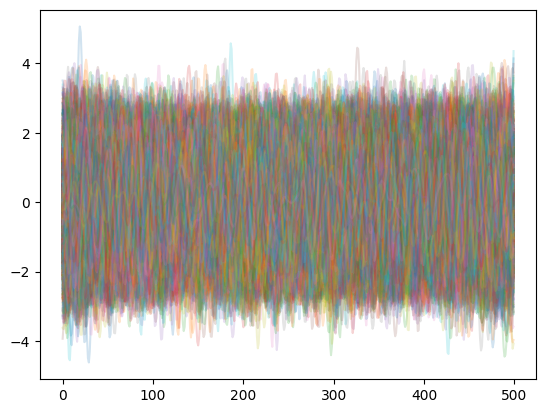

In [8]:
for i in range(x_train.shape[0]):
  plt.plot(x_train[i,:,0], alpha=0.2);

Non ci sono chiare separazioni. I valori sono comparabili.

In [9]:
np.mean(x_train, axis=0)

array([[-1.67083636e-02],
       [-1.52700746e-02],
       [-1.36049646e-02],
       [-1.19433657e-02],
       [-9.96563458e-03],
       [-7.06215854e-03],
       [-3.49478349e-03],
       [ 5.68337139e-04],
       [ 5.35354571e-03],
       [ 1.00318023e-02],
       [ 1.43185290e-02],
       [ 1.76834640e-02],
       [ 1.92819065e-02],
       [ 1.92832407e-02],
       [ 1.76462499e-02],
       [ 1.53215105e-02],
       [ 1.26778018e-02],
       [ 1.05660965e-02],
       [ 8.92237171e-03],
       [ 7.63248125e-03],
       [ 6.55023974e-03],
       [ 4.94030524e-03],
       [ 2.26540298e-03],
       [-1.95007802e-03],
       [-7.54916299e-03],
       [-1.37730872e-02],
       [-1.97437538e-02],
       [-2.44073479e-02],
       [-2.66584802e-02],
       [-2.60196836e-02],
       [-2.23858763e-02],
       [-1.67325540e-02],
       [-1.03652202e-02],
       [-3.87405483e-03],
       [ 2.19682637e-03],
       [ 7.21444784e-03],
       [ 1.07279777e-02],
       [ 1.34667297e-02],
       [ 1.5

In [10]:
np.std(x_train, axis=0)

array([[1.05830832],
       [1.05175759],
       [1.04441532],
       [1.04242851],
       [1.04678796],
       [1.05268313],
       [1.05529256],
       [1.05415822],
       [1.05027861],
       [1.04397469],
       [1.03487399],
       [1.02596224],
       [1.02314081],
       [1.03023736],
       [1.04322972],
       [1.0547483 ],
       [1.05955274],
       [1.05778171],
       [1.05174236],
       [1.04356813],
       [1.03504938],
       [1.02876907],
       [1.0270246 ],
       [1.02994562],
       [1.03433943],
       [1.03705783],
       [1.03711993],
       [1.03454961],
       [1.030334  ],
       [1.02442636],
       [1.01811019],
       [1.01279019],
       [1.00840404],
       [1.00570197],
       [1.00558605],
       [1.00856256],
       [1.01409983],
       [1.02063424],
       [1.0253369 ],
       [1.02702448],
       [1.0266425 ],
       [1.02622788],
       [1.02682364],
       [1.02735369],
       [1.02523568],
       [1.01967015],
       [1.01338405],
       [1.011

Ok, le time series sono normalizzate.

In [11]:
y_train.shape

(3601,)

In [12]:
y_train[0:5]

array([1, 1, 0, 0, 1])

In [13]:
np.unique(y_train)

array([0, 1])

Text(0.5, 1.0, 'Label 0')

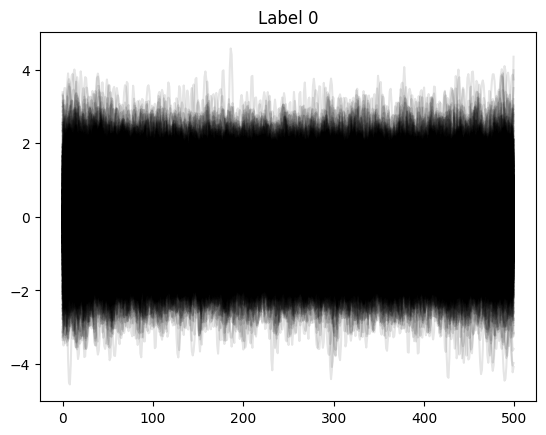

In [14]:
plt.plot(x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==0].T,
         alpha=0.1, color='k');
plt.title("Label 0");

Text(0.5, 1.0, 'Label 1')

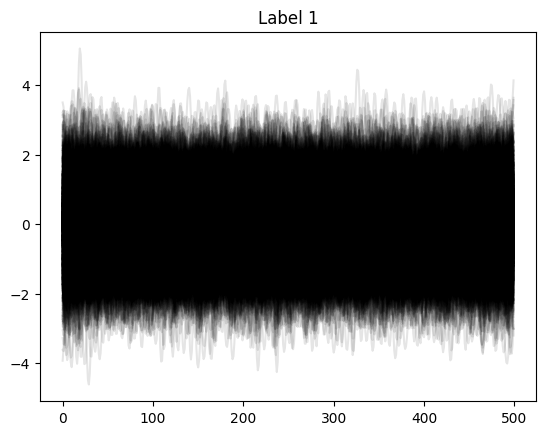

In [15]:
plt.plot(x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==1].T,
         alpha=0.1, color='k');
plt.title("Label 1");

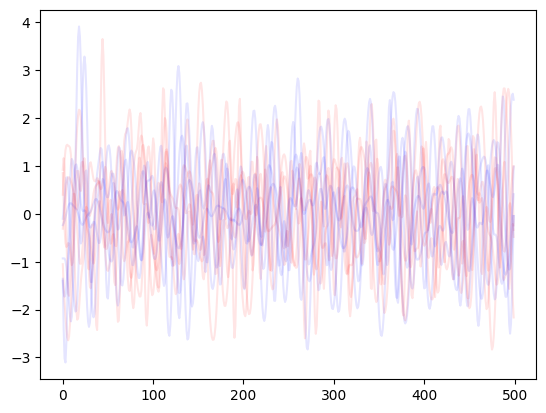

In [16]:
# Plottiamo solo alcune timeseries

plt.plot(x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==0][:5].T,
         alpha=0.1, color='r');
plt.plot(x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==1][:5].T,
         alpha=0.1, color='b');

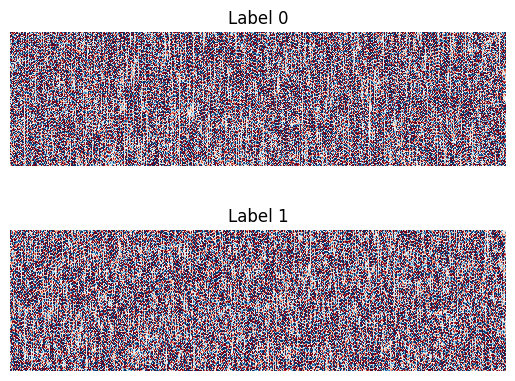

In [17]:
# Visione complessiva di tutto il dataset

fig, ax = plt.subplots(2,1)

ax[0].imshow(x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==0].T,
             interpolation="nearest", clim=(-1,1), cmap="RdBu");
ax[0].axis("off");
ax[0].set_title("Label 0");
ax[1].imshow(x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==1].T,
             interpolation="nearest", clim=(-1,1), cmap="RdBu");
ax[1].axis("off");
ax[1].set_title("Label 1");


Non vediamo struttura, ma almeno non ci sono outliers.

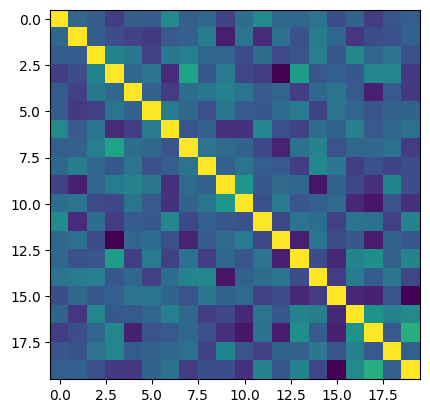

In [18]:
# Matrice di correlazione

twenty_ts = np.concatenate(
    [x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==0][:10].T,
    x_train.reshape(x_train.shape[0], x_train.shape[1])[y_train==1][:10].T],
    axis=1
)
plt.imshow(np.corrcoef(twenty_ts.T));

Anche qui non vediamo correlazioni lineari

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [25]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [21]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [26]:
input_shape = x_train.shape[1:]

"""
create a model with :
4 multiattention heads each size 256, 
4 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

model = keras.models.load_model('transformer_h4_model.h5')
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True)]



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 500, 1)      2           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 500, 1)      7169        ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [28]:
import pickle

In [37]:
with open('transformer_h4_history', "rb") as file_pi:
    history_4h = pickle.load(file_pi)
   

In [46]:
history_4h.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [32]:
import matplotlib.pyplot as plt

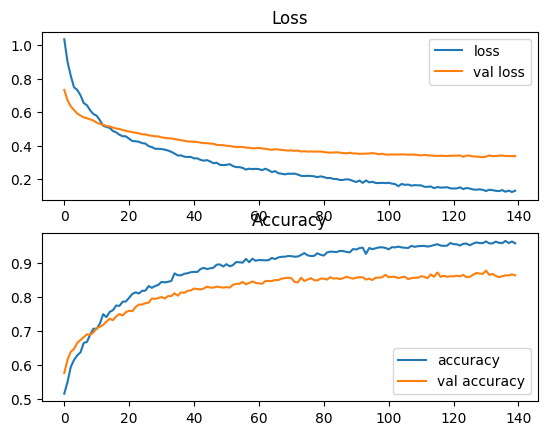

In [48]:
fig, ax = plt.subplots(2,1)

ax[0].plot(history_4h['loss'], label='loss');
ax[0].plot(history_4h['val_loss'], label='val loss');
ax[0].set_title("Loss");
ax[0].legend();

ax[1].plot(history_4h['sparse_categorical_accuracy'], label='accuracy');
ax[1].plot(history_4h['val_sparse_categorical_accuracy'], label='val accuracy');
ax[1].set_title("Accuracy");
ax[1].legend();

We can see some overfitting.

## Conclusions

Official version: In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).

**Reality** these transformer blocks are not doing anything! 
- there is no positional encoding
- the time series are 1D and its not clear that the performance holds going from multivariate (tockenized) to univariate


In [49]:
input_shape = x_train.shape[1:]

"""
create another model with :
1 multiattention head size 256, 
0 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model = build_model(
    input_shape,
    head_size=256,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=0,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 global_average_pooling1d_2   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               64128     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 64,386
Trainable params: 64,386
Non-trainable params: 0
_______________________________________________________

In [58]:
history_new = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                        epochs=200, callbacks=[callbacks], verbose=1,
                        batch_size=50)

Epoch 1/200
73/73 [==============================] - 2s 15ms/step - loss: 0.9411 - sparse_categorical_accuracy: 0.5351 - val_loss: 0.6963 - val_sparse_categorical_accuracy: 0.5871
Epoch 2/200
73/73 [==============================] - 1s 9ms/step - loss: 0.8177 - sparse_categorical_accuracy: 0.5785 - val_loss: 0.6368 - val_sparse_categorical_accuracy: 0.6462
Epoch 3/200
73/73 [==============================] - 1s 7ms/step - loss: 0.7542 - sparse_categorical_accuracy: 0.6126 - val_loss: 0.5999 - val_sparse_categorical_accuracy: 0.6689
Epoch 4/200
73/73 [==============================] - 0s 5ms/step - loss: 0.7011 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.5779 - val_sparse_categorical_accuracy: 0.6970
Epoch 5/200
73/73 [==============================] - 0s 5ms/step - loss: 0.6504 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.5634 - val_sparse_categorical_accuracy: 0.7098
Epoch 6/200
73/73 [==============================] - 0s 5ms/step - loss: 0.6271 - sparse_categorical_acc

In [ ]:
mode

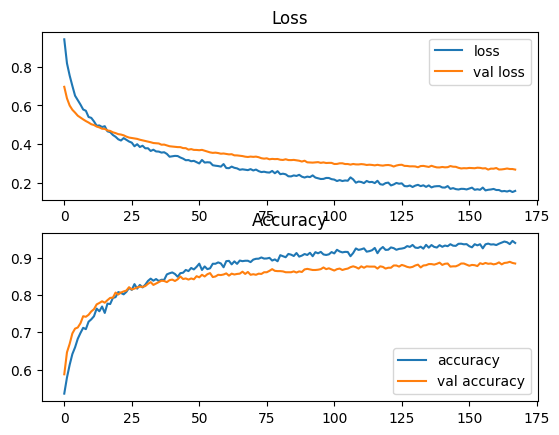

In [60]:
fig, ax = plt.subplots(2,1)

ax[0].plot(history_new.history['loss'], label='loss');
ax[0].plot(history_new.history['val_loss'], label='val loss');
ax[0].set_title("Loss");
ax[0].legend();

ax[1].plot(history_new.history['sparse_categorical_accuracy'],
           label='accuracy');
ax[1].plot(history_new.history['val_sparse_categorical_accuracy'],
           label='val accuracy');
ax[1].set_title("Accuracy");
ax[1].legend();

Non vediamo grandi differenze rispetto al modello precedente più complicato.